In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

In [2]:
latent_dim = 2
vector_dim = 2
model_dim = 512

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(latent_dim, model_dim),
            nn.ReLU(),
            
            nn.Linear(model_dim, model_dim),
            nn.ReLU(),

            nn.Linear(model_dim, model_dim),
            nn.ReLU(),
            
            nn.Linear(model_dim, vector_dim)
        )
    def forward(self, x):
        return self.seq(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(vector_dim, model_dim),
            nn.ReLU(),
            
            nn.Linear(model_dim, model_dim),
            nn.ReLU(),

            nn.Linear(model_dim, model_dim),
            nn.ReLU(),
            
            nn.Linear(model_dim, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.seq(x)

In [4]:
torch.manual_seed(1)
c1 = torch.cat([0.1*torch.randn(20000, 1)+2, 0.1*torch.randn(20000, 1)+0], 1)
c2 = torch.cat([0.1*torch.randn(20000, 1)-2, 0.1*torch.randn(20000, 1)+0], 1)

c3 = torch.cat([0.1*torch.randn(20000, 1)+0, 0.1*torch.randn(20000, 1)+2], 1)
c4 = torch.cat([0.1*torch.randn(20000, 1)+0, 0.1*torch.randn(20000, 1)-2], 1)

c5 = torch.cat([0.1*torch.randn(20000, 1)-np.sqrt(2), 0.1*torch.randn(20000, 1)-np.sqrt(2)], 1)
c6 = torch.cat([0.1*torch.randn(20000, 1)-np.sqrt(2), 0.1*torch.randn(20000, 1)+np.sqrt(2)], 1)

c7 = torch.cat([0.1*torch.randn(20000, 1)+np.sqrt(2), 0.1*torch.randn(20000, 1)-np.sqrt(2)], 1)
c8 = torch.cat([0.1*torch.randn(20000, 1)+np.sqrt(2), 0.1*torch.randn(20000, 1)+np.sqrt(2)], 1)

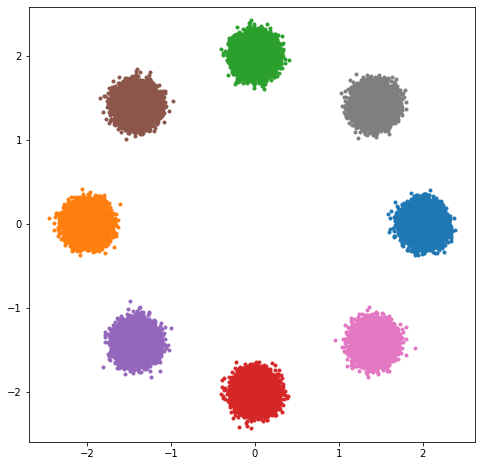

In [5]:
plt.gcf().set_size_inches(8, 8)

plt.scatter(c1[:,0].numpy(), c1[:,1].numpy(), marker='.')
plt.scatter(c2[:,0].numpy(), c2[:,1].numpy(), marker='.')
plt.scatter(c3[:,0].numpy(), c3[:,1].numpy(), marker='.')
plt.scatter(c4[:,0].numpy(), c4[:,1].numpy(), marker='.')
plt.scatter(c5[:,0].numpy(), c5[:,1].numpy(), marker='.')
plt.scatter(c6[:,0].numpy(), c6[:,1].numpy(), marker='.')
plt.scatter(c7[:,0].numpy(), c7[:,1].numpy(), marker='.')
plt.scatter(c8[:,0].numpy(), c8[:,1].numpy(), marker='.')
plt.axis('equal')
plt.show()

In [6]:
device = 'cuda'

In [7]:
dataset = TensorDataset(torch.cat([c1, c2, c3, c4, c5, c6, c7, c8]).to(device))

In [8]:
G = Generator().to(device)
D = Discriminator().to(device)

In [9]:
gp_lambda = 10
n_critic = 5
learning_rate = 1e-4
beta_1 = 0.5
beta_2 = 0.9
batch_size = 256

In [10]:
D_optimizer = optim.Adam(D.parameters(), lr=learning_rate, betas=(beta_1, beta_2))
G_optimizer = optim.Adam(G.parameters(), lr=learning_rate, betas=(beta_1, beta_2))

In [11]:
class UniformDatasetSampler:
    def __init__(self, dataset):
        self.dataset = dataset
    def get_batch(self, batch_size):
        idx = torch.randint(0, len(self.dataset), (batch_size, ))
        return self.dataset[idx][0].clone()

In [12]:
class UniformLatentSampler:
    def __init__(self, latent_dim, low=-1, high=1):
        self.latent_dim = latent_dim
        self.low = -1
        self.high = 1

    def get_batch(self, batch_size):
        return (self.high - self.low) * torch.rand((batch_size, self.latent_dim)).to(device) + self.low

In [13]:
data_sampler = UniformDatasetSampler(dataset)
noise_sampler = UniformLatentSampler(latent_dim)

In [14]:
losses = {
    'D':[],
    'G':[]
}

In [15]:
adv_crit = nn.BCELoss().to(device)

In [16]:
D.train()
G.train()
for t in range(20000):
    D.zero_grad()

    # compute real data loss
    x_real = data_sampler.get_batch(batch_size)
    real_pred = D(x_real)

    # compute fake data loss
    z_fake = noise_sampler.get_batch(batch_size)
    x_fake = G(z_fake).detach()
    fake_pred = D(x_fake)
    
    # backpropagate and step
    D_loss = adv_crit(fake_pred, torch.zeros(batch_size, 1).to(device)) + adv_crit(real_pred, torch.ones(batch_size, 1).to(device))
    D_loss.backward()
    D_optimizer.step()
    
    if t % n_critic == 0:
        G.zero_grad()
        
        # compute loss
        z_fake = noise_sampler.get_batch(batch_size)
        x_fake = G(z_fake)
        fake_pred = D(x_fake)

        # backpropagate and step
        G_loss = adv_crit(fake_pred, torch.ones(batch_size, 1).to(device)) 
        G_loss.backward()
        G_optimizer.step()
                
    losses['D'].append(D_loss.item())
    losses['G'].append(G_loss.item())

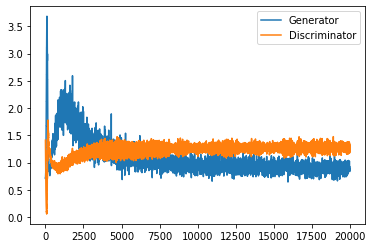

In [17]:
plt.plot(losses['G'], label='Generator')
plt.plot(losses['D'], label='Discriminator')
plt.legend()
plt.show()

In [18]:
G.eval()

Generator(
  (seq): Sequential(
    (0): Linear(in_features=2, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=2, bias=True)
  )
)

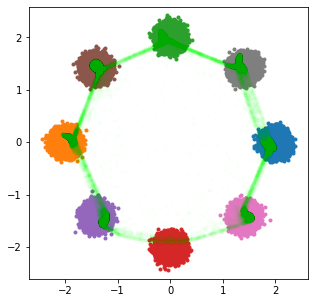

In [19]:
plt.gcf().set_size_inches(5, 5)
plt.scatter(c1[:,0].numpy(), c1[:,1].numpy(), marker='.')
plt.scatter(c2[:,0].numpy(), c2[:,1].numpy(), marker='.')
plt.scatter(c3[:,0].numpy(), c3[:,1].numpy(), marker='.')
plt.scatter(c4[:,0].numpy(), c4[:,1].numpy(), marker='.')
plt.scatter(c5[:,0].numpy(), c5[:,1].numpy(), marker='.')
plt.scatter(c6[:,0].numpy(), c6[:,1].numpy(), marker='.')
plt.scatter(c7[:,0].numpy(), c7[:,1].numpy(), marker='.')
plt.scatter(c8[:,0].numpy(), c8[:,1].numpy(), marker='.')
generated = G(2*torch.rand(100000, latent_dim).to(device)-1).detach().cpu().numpy()
plt.scatter(generated[:,0], generated[:,1], marker='.', color=(0, 1, 0, 0.01))
plt.axis('equal')
plt.show()